In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [4]:
f(3.0)

20.0

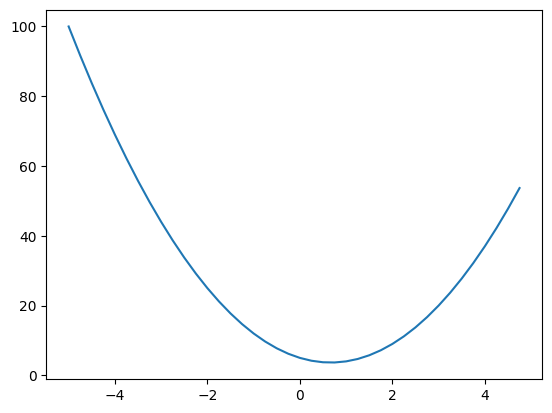

In [7]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)
plt.show()

In [8]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [9]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4.0
d2 4.0001
slope 0.9999999999976694


In [4]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [11]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


In [14]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

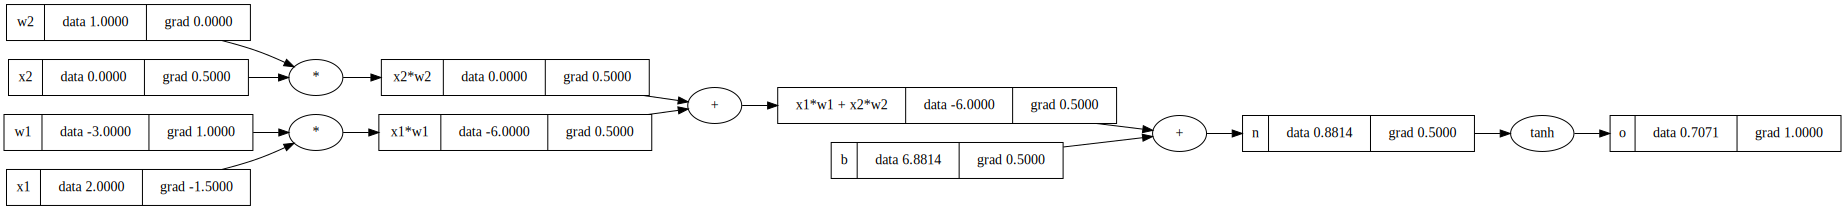

In [15]:
draw_dot(o)

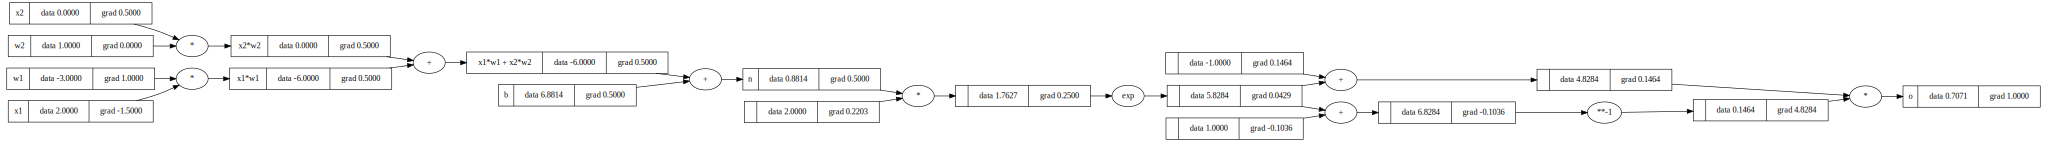

In [16]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ----
e = (2*n).exp()
o = (e - 1) / (e + 1)
# ----
o.label = 'o'
o.backward()
draw_dot(o)

In [28]:
import torch
import random

In [19]:
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [25]:
o.item()
x2.grad

tensor([0.5000], dtype=torch.float64)

In [6]:
from typing import Any, List
import random

class Neuron:
    def __init__(self, nin) -> None:
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x) -> Any:
        # w * x + b
        act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b
        out = act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    

class Layer:
    def __init__(self, nin, nout) -> None:
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x: Any) -> Any:
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
    
        # params = []
        # for neuron in self.neurons:
        #     params.extend(neuron.parameters())
        # return params
    

class MLP:
    def __init__(self, nin: int, nouts: List[int]) -> None:
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x: Any) -> Any:
        for layer in self.layers:
            x = layer(x)

        return x
    
    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]


x = [2.0, 3.0]
n = Neuron(2)
n(x)

l = Layer(2, 3)
l(x)

x = [2.0, 3.0, -1.0]
mlp = MLP(3, [4, 4, 1])
mlp(x)

Value(data=0.2070349737967996)

In [77]:
# draw_dot(mlp(x))

In [78]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets
ypred = [mlp(x) for x in xs]
ypred

[Value(data=0.823241074050659),
 Value(data=0.9618803690491831),
 Value(data=-0.41146246922235497),
 Value(data=0.8970883731490772)]

In [79]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)])
loss    # we want to minimize this

Value(data=4.237185528438274)

In [91]:
loss.backward()

In [81]:
mlp.layers[0].neurons[0].w[0].grad
# we see that the gradient of the weight in this neuron in this layer is positive so it impacts the loss positively and we need to lower the value of that weight

0.012810770203804753

In [86]:
mlp.layers[0].neurons[0].w[0].data

0.5257316903823999

In [82]:
# draw_dot(loss)

In [119]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [120]:
mlp.layers[0].neurons[0].w[0].data

0.5225838023047935

## Manual gradient descent

### Forward pass

In [215]:
ypred = [mlp(x) for x in xs]
loss = sum([(yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)])
loss    # we want to minimize this

Value(data=0.011276742204239638)

### Backward pass

In [216]:
loss.backward()

### Update

In [217]:
for p in mlp.parameters():
    p.data += -0.01 * p.grad

In [218]:
ypred

[Value(data=0.9257197015064403),
 Value(data=-0.999392608235118),
 Value(data=-0.9993040342263962),
 Value(data=0.9241163643014303)]

In [220]:
mlp.parameters()

[Value(data=-0.09055965380145388),
 Value(data=-1.2431144006166732),
 Value(data=0.5712562879541221),
 Value(data=-0.904470158337975),
 Value(data=1.7311952998124316),
 Value(data=2.216432872363274),
 Value(data=-3.965619664055589),
 Value(data=0.025466106496987),
 Value(data=2.6956021999768605),
 Value(data=0.11781361045935491),
 Value(data=1.1620972024642595),
 Value(data=1.2709942618723606),
 Value(data=-2.435052049876963),
 Value(data=4.8041908205939),
 Value(data=-5.443367249721783),
 Value(data=-0.32924135798299836),
 Value(data=-0.852450067114378),
 Value(data=-0.7237063254789532),
 Value(data=1.0161652057739874),
 Value(data=-0.28659338074220436),
 Value(data=0.6673636736496956),
 Value(data=-0.3212514302310779),
 Value(data=0.8132605779328677),
 Value(data=1.190593682776379),
 Value(data=3.038653162481389),
 Value(data=-0.3508830606134757),
 Value(data=-1.4443723982825962),
 Value(data=0.930712683105643),
 Value(data=2.1272009883332688),
 Value(data=3.208999737877447),
 Value(

In [9]:
mlp = MLP(2, [4, 4, 1])

for k in range(10):

    # forward pass
    ypred = [mlp(x) for x in xs]
    loss = sum([(yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)])
    
    # backward pass
    # NOTE: we need to flush the grads as they do a += on every pass on the grad so they just add up and never reset to 0
    for p in mlp.parameters():
        p.grad = 0.0    # we get slower results

    loss.backward()

    # NOTE: the reason why this problem worked before implementing zero grad is becuase it is a very simple problem so we basically created an update with a big step
    # NOTE: on a more complex problem, we would probably not have a good solution at the end

    # TODO: provjeri cancer classification radis li to 
    
    # update
    for p in mlp.parameters():
        p.data += -0.01 * p.grad

    print(f"Step {k}: loss: {loss.data}")

NameError: name 'xs' is not defined

In [228]:
ypred

[Value(data=0.8551732926792938),
 Value(data=-0.7793688420447794),
 Value(data=-0.8075094551769244),
 Value(data=0.7800460271021705)]

## L2 regularization implementation

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

%matplotlib inline

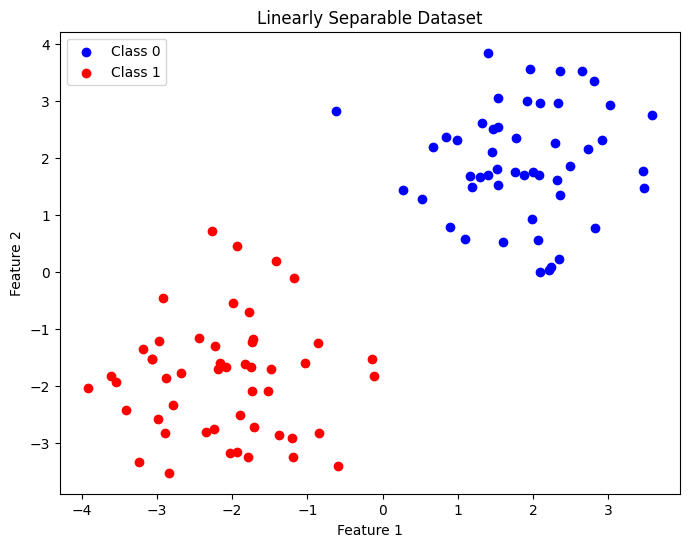

In [30]:
# Set random seed for reproducibility
np.random.seed(42)

# Generate points for class 0
class_0 = np.random.randn(50, 2) + np.array([2, 2])
# Generate points for class 1
class_1 = np.random.randn(50, 2) + np.array([-2, -2])

# Combine the points into a single dataset
X = np.vstack((class_0, class_1))
y = np.hstack((np.zeros(50), np.ones(50)))

# Plot the dataset
plt.figure(figsize=(8, 6))
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Class 0')
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Class 1')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Linearly Separable Dataset')
plt.legend()

# # Compute and plot the decision boundary
# x_range = [X[:, 0].min() - 1, X[:, 0].max() + 1, X[:, 1].min() - 1, X[:, 1].max() + 1]
# X1, X2, preds = decision_boundary(mlp, x_range)
# plt.contour(X1, X2, preds, levels=[0.5], colors='black')

plt.show()

In [22]:
# Function to compute the decision boundary
def decision_boundary(nn, x_range):
    x1_vals = np.linspace(x_range[0], x_range[1], 100)
    x2_vals = np.linspace(x_range[2], x_range[3], 100)
    X1, X2 = np.meshgrid(x1_vals, x2_vals)
    grid = np.c_[X1.ravel(), X2.ravel()]    
    preds = nn(grid).reshape(X1.shape)
    return X1, X2, preds

In [19]:
mlp = MLP(3, [4, 4, 1])
xs = X
ys = y

for k in range(50):

    # forward pass
    ypred = [mlp(x) for x in xs]
    l2reg = sum([p**2 for p in mlp.parameters()])
    loss = sum([(yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)]) + l2reg
    
    # backward pass
    # NOTE: we need to flush the grads as they do a += on every pass on the grad so they just add up and never reset to 0
    for p in mlp.parameters():
        p.grad = 0.0    # we get slower results

    loss.backward()

    # TODO: provjeri cancer classification radis li to 
    
    # update
    for p in mlp.parameters():
        p.data += -0.01 * p.grad

    print(f"Step {k}: loss: {loss.data}")

    # TODO: compare the losses after implementation 

Step 0: loss: 160.8456028867923
Step 1: loss: 53.84703732118629
Step 2: loss: 27.863034218334906
Step 3: loss: 53.37791283406504
Step 4: loss: 22.640276454026882
Step 5: loss: 42.74273142116843
Step 6: loss: 43.52915809334785
Step 7: loss: 38.478931090269185
Step 8: loss: 45.93616451382829
Step 9: loss: 26.108718263167553
Step 10: loss: 49.66393058570606
Step 11: loss: 14.758947424954329
Step 12: loss: 15.315631189276257
Step 13: loss: 25.47579791382914
Step 14: loss: 46.47633107097699
Step 15: loss: 13.007458896710405
Step 16: loss: 17.610790355872332
Step 17: loss: 38.71615938861019
Step 18: loss: 22.790993872054564
Step 19: loss: 40.124460426037565
Step 20: loss: 14.486881581661205
Step 21: loss: 30.04258560846464
Step 22: loss: 27.957614382940932
Step 23: loss: 25.227603222266644
Step 24: loss: 25.185376834100538
Step 25: loss: 17.15833095693633
Step 26: loss: 19.845607615730586
Step 27: loss: 12.344797712194525
Step 28: loss: 13.372383474568002
Step 29: loss: 10.763297023647036
St

## Learning decay implementation

We will implement a simple linear linear decay scheduler. 

In [29]:
mlp = MLP(3, [5, 5, 1])
xs = X
ys = y
lr = 0.01
decay = 0.1

for k in range(100):

    # forward pass
    ypred = [mlp(x) for x in xs]
    l2reg = sum([p**2 for p in mlp.parameters()])
    loss = sum([(yout - ytrue)**2 for yout, ytrue in zip(ypred, ys)]) + l2reg
    
    # backward pass
    # NOTE: we need to flush the grads as they do a += on every pass on the grad so they just add up and never reset to 0
    for p in mlp.parameters():
        p.grad = 0.0    # we get slower results

    loss.backward()

    # update
    for p in mlp.parameters():
        p.data += -lr * p.grad

    if (k+1) % 20 == 0:
        print(f"Decaying the learning rate from {lr} to {lr * decay} at step {k}.")
        lr *= decay

    print(f"Step {k}: loss: {loss.data}")

    # TODO: compare the losses after implementation 

Step 0: loss: 49.81373027318564
Step 1: loss: 45.595580331677276
Step 2: loss: 32.25471173578123
Step 3: loss: 45.68683204910354
Step 4: loss: 18.809567755690658
Step 5: loss: 21.50531892103628
Step 6: loss: 30.990615063419302
Step 7: loss: 31.4896192686005
Step 8: loss: 25.006343220161227
Step 9: loss: 24.76318935291764
Step 10: loss: 24.23937394998809
Step 11: loss: 21.415886873446826
Step 12: loss: 20.81151638816751
Step 13: loss: 18.243695898379816
Step 14: loss: 17.541956118597227
Step 15: loss: 15.601924906500397
Step 16: loss: 14.930103671640705
Step 17: loss: 13.612503966293339
Step 18: loss: 13.041859275120148
Decaying the learning rate from 0.01 to 0.001 at step 19.
Step 19: loss: 12.148340763728063
Step 20: loss: 11.671068043743968
Step 21: loss: 11.030099878022968
Step 22: loss: 10.584146208518
Step 23: loss: 10.276525811809451
Step 24: loss: 10.063954607836594
Step 25: loss: 9.91525449321939
Step 26: loss: 9.808825970347543
Step 27: loss: 9.730092083198864
Step 28: loss: 9